In [5]:
import sys

# 推奨された方法ではない。
# 参照:https://note.com/iamhacchin/n/n8eb3efafadf9
sys.path.append("../scripts/")
from ideal_robot import *
from scipy.stats import expon, norm


In [6]:
# 移動速度へのバイアスを実装
class Robot(IdealRobot):
    def __init__(
        self,
        pose,
        agent=None,
        sensor=None,
        color="black",
        noise_per_meter=5,
        noise_std=math.pi / 60,
        bias_rate_stds=(0.1, 0.1),
    ):
        """コンストラクタ

        Args:
            pose (_type_): _description_
            agent (_type_, optional): _description_. Defaults to None.
            sensor (_type_, optional): _description_. Defaults to None.
            color (str, optional): _description_. Defaults to "black".
            noise_per_meter (int, optional): 1mあたりの小石の数. Defaults to 5.
            noise_std (_type_, optional): 小石を踏んだときにロボットの向きθに発生するノイズの標準偏差[deg]. Defaults to math.pi/60.
            bias_rate_stds (_type_, optional): 移動速度に付与するバイアス係数を生成するためのガウス分布の標準偏差. Defaults to (0.1,0.1)
        """
        super().__init__(pose, agent, sensor, color)
        # 指数分布のオブジェクト生成
        # scaleはλの逆数に相当する。1e-100はゼロ割を防止するためのテクニック
        self.noise_pdf = expon(scale=1.0 / (1e-100 + noise_per_meter))
        # 最初に小石を踏むまでの道のりを指数分布からrvs()を使ってドローしている
        self.distance_until_noise = self.noise_pdf.rvs()
        # θに加えるノイズを決めるためのガウス分布のオブジェクトを生成
        self.theta_noise = norm(scale=noise_std)
        # 移動速度、角速度のバイアスを生成＝ガウス分布からドロー
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])

    def noise(self, pose, nu, omega, time_interval):

        # このメソッドが呼ばれるたびにdistance_until_noiseを経過時間分だけ減らす。
        # abs(nu) * time_interval = 速度nu[m/s]をtime_interval間続けたとき、つまり直進方向の移動距離[m]
        # self.r * abs(omega) * time_interval = 半径r[m]のロボットが角速度omega[rad/s]をtime_interval間続けたとき、つまり回転方向の移動距離[m]
        # @note 回転方向の速度vはr*omegaで得られる。速度vに時間をかけて移動距離を算出
        self.distance_until_noise -= (
            abs(nu) * time_interval + self.r * abs(omega) * time_interval
        )

        # 0以下なら小石を踏んだを判定
        if self.distance_until_noise <= 0.0:
            # 新しい小石を踏むまでの道のりを生成
            self.distance_until_noise += self.noise_pdf.rvs()
            # ロボットの向きにノイズを付与
            pose[2] += self.theta_noise.rvs()

        return pose

    def bias(self, nu, omega):
        return nu * self.bias_rate_nu, omega * self.bias_rate_omega

    def one_step(self, time_interval):
        if not self.agent:
            return
        if self.sensor:
            obs = self.sensor.data(self.pose)
        else:
            obs = None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        # noiseを実行する行を追加
        self.pose = self.noise(self.pose, nu, omega, time_interval)


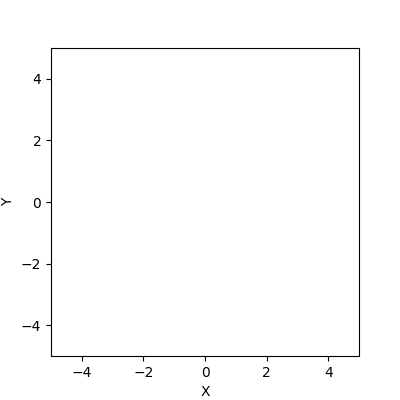

In [8]:
import copy

world = World(30, 0.1)
circling=Agent(0.2, 10.0/180*math.pi)
nobias_robot=IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray")
world.append(nobias_robot)
biased_robot=Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red", noise_per_meter=0,bias_rate_stds=(0.5,0.5))
world.append(biased_robot)
%matplotlib widget
world.draw()


指数分布の確率密度関数の式(4.1)
$$
p(x|\lambda) = {\lambda}{e}^{-{\lambda}{x}}
$$

Robotクラスでは上記の式を用いて、環境にランダムに小石が落ちておりそれを踏んだ直後にロボットの向きθをランダムにずらすプログラムを実装している。

$\lambda$は道のりあたりに踏みつける小石の数の期待値に相当する。逆数の$1/\lambda$は小石１つ踏みつけるまでの道のりの期待値に相当する。